# ASL Project

In [2]:
#Import libraries
import numpy as np
import random

# Imports to view data
import cv2
import pandas as pd
from glob import glob

# Visualization
from keras.utils import print_summary
from matplotlib import pyplot as plt

#ML libraries
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [3]:
#Directory paths
TRAIN_DIR = "../Dataset/asl_alphabet_train/asl_alphabet_train"
TEST_DIR = "../Dataset/asl_alphabet_test"
MODEL_DIR = './Model'
MODEL_PATH = MODEL_DIR+"/Model1.h5"
MODEL_WEIGHT_PATH = MODEL_DIR+"/Model_Weight1.h5"

In [4]:
# Set global variables
TARGET_SIZE = (64, 64)
TARGET_DIMS = (64, 64, 3) # add channel for RGB
CLASSES = 29
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 64
LABELS_NAME = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q',
               'R','S','T','U','V','W','X','Y','Z','del','nothing','space']

In [18]:
def plot_sample(base_path):
    cols = 5
    rows = int(np.ceil(len(LABELS_NAME) / cols))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(LABELS_NAME)):
        folder_name = LABELS_NAME[i]
        img_path = base_path +'/' + folder_name + '/**'
        path_contents = glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(folder_name)
        sp.axis('off')

    plt.show()
    return

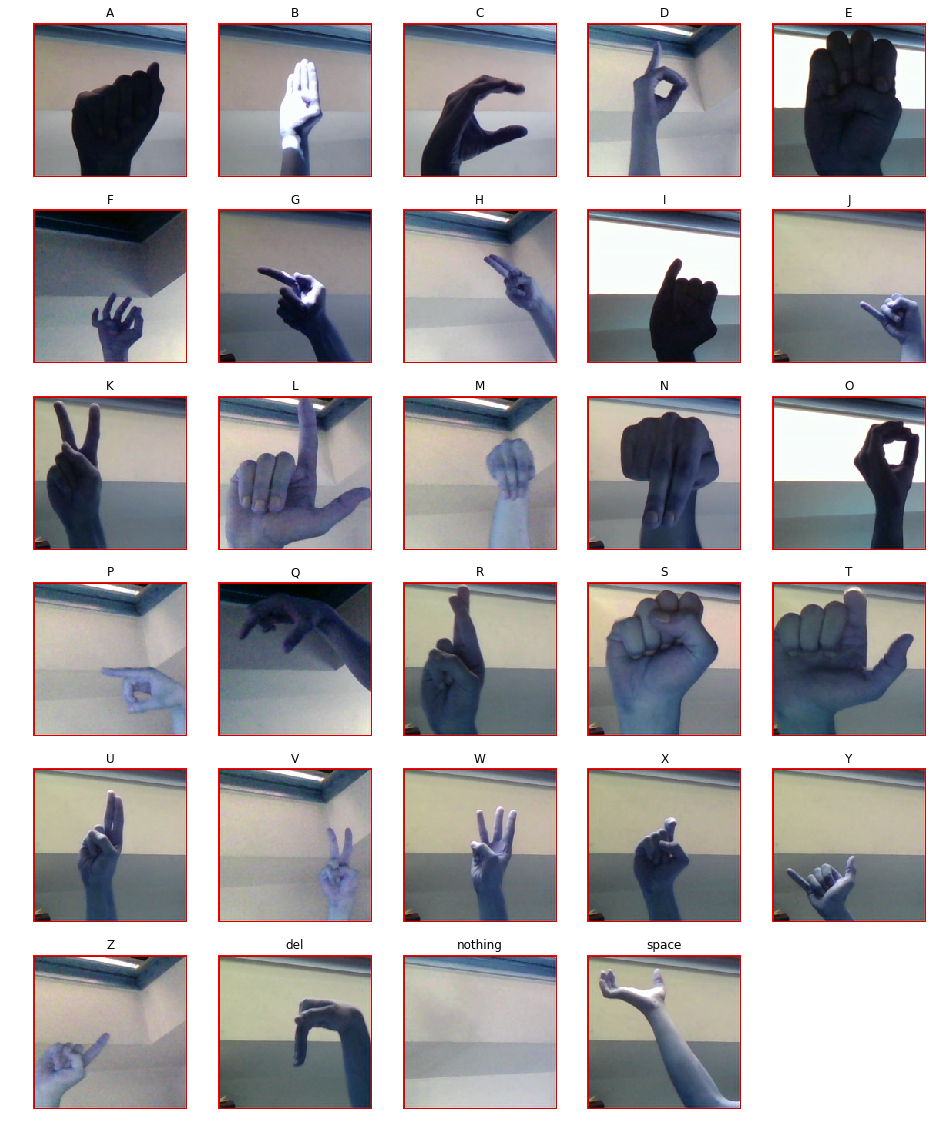

In [19]:
#Plot sample of train dataset
plot_sample(TRAIN_DIR)

## Data Augmentation

In [5]:
#Load Train dataset
train_image_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=VALIDATION_SPLIT
)

validation_image_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=VALIDATION_SPLIT
)

train_generator = train_image_generator.flow_from_directory(TRAIN_DIR, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, shuffle=True, subset="training")
val_generator = validation_image_generator.flow_from_directory(TRAIN_DIR, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


## Model

In [27]:
#Define Model VGG16 Model
def VGG16_model_build():
    from keras.applications.vgg16 import VGG16
    from keras.layers import Input

    input_tensor = Input(shape=TARGET_DIMS)
    model = VGG16(input_tensor = input_tensor, weights=None, include_top=True, classes= CLASSES)
    return model

In [28]:
from keras.models import Model
base_model = VGG16_model_build()
x = base_model.output
#x = (Dense(CLASSES, activation='softmax'))(x)
model = Model(inputs=base_model.input, outputs=x)

#Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()
model.save(MODEL_PATH)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [36]:
#Checkpointer to save the best models
checkpointer = ModelCheckpoint(filepath=MODEL_WEIGHT_PATH, 
                               verbose=1, save_best_only=True)

steps_per_epoch = int( np.ceil(len(train_generator)*4 / BATCH_SIZE) )
validation_steps = int( np.ceil(len(val_generator)*4 / BATCH_SIZE) )

model.fit_generator(train_generator, validation_data=val_generator, 
                    steps_per_epoch =  steps_per_epoch,
                    validation_steps = validation_steps,
                    epochs=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
77/77 [==============================] - 574s 7s/step - loss: 15.6013 - acc: 0.0321 - val_loss: 15.5305 - val_acc: 0.0365

Epoch 00001: val_loss improved from inf to 15.53046, saving model to ./Model/Model_Weight1.h5
Epoch 2/20
77/77 [==============================] - 585s 8s/step - loss: 15.5326 - acc: 0.0363 - val_loss: 15.6704 - val_acc: 0.0278

Epoch 00002: val_loss did not improve from 15.53046
Epoch 3/20
77/77 [==============================] - 591s 8s/step - loss: 15.5326 - acc: 0.0363 - val_loss: 15.6984 - val_acc: 0.0260

Epoch 00003: val_loss did not improve from 15.53046
Epoch 4/20
77/77 [==============================] - 598s 8s/step - loss: 15.5653 - acc: 0.0343 - val_loss: 15.4465 - val_acc: 0.0417

Epoch 00004: val_loss improved from 15.53046 to 15.44651, saving model to ./Model/Model_Weight1.h5
Epoch 5/20
77/77 [==============================] - 603s 8s/step - loss: 15.5359 - acc: 0.0361 - val_loss: 15.3346 - val_acc: 0.0486

Epoch 00005: val_loss improved fr

In [37]:
#Predict on validation dataset
predictions = model.predict_generator(val_generator, steps=1)        
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

predictions = [label_map[k] for k in predictions]

print(predictions, len(predictions))

loss, acc = model.evaluate_generator(val_generator, steps=1, verbose=0)

print(loss,",",acc)

['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'] 64
15.866250038146973 , 0.015625


In [38]:
test_image_generator = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
)

test_generator = test_image_generator.flow_from_directory(TEST_DIR, target_size=TARGET_SIZE, batch_size=28, shuffle=False, 
    class_mode='categorical')
print(test_generator.classes)

Found 28 images belonging to 1 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [39]:
#Predict
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=1)
predictions = np.argmax(predictions, axis=1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

predictions = [label_map[k] for k in predictions]

print(predictions, len(predictions))

['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'] 28


In [40]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)

                              Filename Predictions
0         asl_alphabet_test\A_test.jpg           E
1         asl_alphabet_test\B_test.jpg           E
2         asl_alphabet_test\C_test.jpg           E
3         asl_alphabet_test\D_test.jpg           E
4         asl_alphabet_test\E_test.jpg           E
5         asl_alphabet_test\F_test.jpg           E
6         asl_alphabet_test\G_test.jpg           E
7         asl_alphabet_test\H_test.jpg           E
8         asl_alphabet_test\I_test.jpg           E
9         asl_alphabet_test\J_test.jpg           E
10        asl_alphabet_test\K_test.jpg           E
11        asl_alphabet_test\L_test.jpg           E
12        asl_alphabet_test\M_test.jpg           E
13        asl_alphabet_test\N_test.jpg           E
14        asl_alphabet_test\O_test.jpg           E
15        asl_alphabet_test\P_test.jpg           E
16        asl_alphabet_test\Q_test.jpg           E
17        asl_alphabet_test\R_test.jpg           E
18        asl_alphabet_test\S_t

In [41]:
count = 0
for file,prediction in zip(filenames,predictions):
    #print(file,prediction)
    if(prediction+'_test' in file):
        count+=1
        
print("accuracy",count/len(filenames)*100)

accuracy 3.571428571428571


In [ ]:
#https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad
#https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
#

In [10]:
#Define Model VGG16 Model with pretrained weight
def VGG16_model_build_weight():
    from keras.applications.vgg16 import VGG16
    from keras.layers import Input

    input_tensor = Input(shape=TARGET_DIMS)
    model = VGG16(input_tensor = input_tensor, weights='imagenet', include_top=False)
    return model

from keras.models import Model
weight_base_model = VGG16_model_build_weight()
x1 = weight_base_model.output
#Add the fully-connected layers 
x1 = Flatten(name='flatten')(x1)
x1 = Dense(4096, activation='relu', name='fc1')(x1)
x1 = Dense(4096, activation='relu', name='fc2')(x1)
x1 = Dense(CLASSES, activation='softmax', name='predictions')(x1)
weight_model = Model(inputs=weight_base_model.input, outputs=x1)

#Compile the model
weight_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

weight_model.summary()
MODEL_PATH = MODEL_DIR+"/Model1-withweight.h5"
weight_model.save(MODEL_PATH)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [12]:
#Checkpointer to save the best models
MODEL_WEIGHT_PATH = MODEL_DIR+"/Model_Weight1-withweight.h5"
checkpointer = ModelCheckpoint(filepath=MODEL_WEIGHT_PATH, 
                               verbose=1, save_best_only=True)

steps_per_epoch = int( np.ceil(len(train_generator)*2 / BATCH_SIZE) )
validation_steps = int( np.ceil(len(val_generator)*2 / BATCH_SIZE) )

weight_model.fit_generator(train_generator, validation_data=val_generator, 
                    steps_per_epoch =  steps_per_epoch,
                    validation_steps = validation_steps,
                    epochs=10, callbacks=[checkpointer], verbose=1)

Epoch 1/10
39/39 [==============================] - 300s 8s/step - loss: 15.5434 - acc: 0.0357 - val_loss: 15.7151 - val_acc: 0.0250

Epoch 00001: val_loss improved from inf to 15.71514, saving model to ./Model/Model_Weight1-withweight.h5
Epoch 2/10
39/39 [==============================] - 294s 8s/step - loss: 15.6661 - acc: 0.0280 - val_loss: 15.7655 - val_acc: 0.0219

Epoch 00002: val_loss did not improve from 15.71514
Epoch 3/10
39/39 [==============================] - 296s 8s/step - loss: 15.5950 - acc: 0.0325 - val_loss: 15.4633 - val_acc: 0.0406

Epoch 00003: val_loss improved from 15.71514 to 15.46330, saving model to ./Model/Model_Weight1-withweight.h5
Epoch 4/10
39/39 [==============================] - 300s 8s/step - loss: 15.4788 - acc: 0.0397 - val_loss: 15.2115 - val_acc: 0.0563

Epoch 00004: val_loss improved from 15.46330 to 15.21145, saving model to ./Model/Model_Weight1-withweight.h5
Epoch 5/10
39/39 [==============================] - 305s 8s/step - loss: 15.5886 - acc:

In [13]:
#Predict on validation dataset
predictions = weight_model.predict_generator(val_generator, steps=1)        
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

predictions = [label_map[k] for k in predictions]

print(predictions, len(predictions))

loss, acc = weight_model.evaluate_generator(val_generator, steps=1, verbose=0)

print(loss,",",acc)

['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S'] 64
15.866250038146973 , 0.015625


In [14]:
test_image_generator = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
)

test_generator = test_image_generator.flow_from_directory(TEST_DIR, target_size=TARGET_SIZE, batch_size=28, shuffle=False, 
    class_mode='categorical')
print(test_generator.classes)

Found 28 images belonging to 1 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
#Predict
test_generator.reset()
predictions = weight_model.predict_generator(test_generator, steps=1)
predictions = np.argmax(predictions, axis=1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

predictions = [label_map[k] for k in predictions]

print(predictions, len(predictions))

['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S'] 28


In [18]:
filenames=test_generator.filenames
count = 0
for file,prediction in zip(filenames,predictions):
    #print(file,prediction)
    if(prediction+'_test' in file):
        count+=1
        
print("accuracy",count/len(filenames)*100)

accuracy 3.571428571428571
